<a href="https://colab.research.google.com/github/Peanut888/Mario-Game-Clone/blob/main/tutorial_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focused Ultrasound Workshop
Callum Rhys Tilbury, Non-invasive Surgery & Biopsy Lab, Imperial College London

12 February 2026

## Frontmatter

### Imports

First, we need to import the necessary libraries. We will be using j-wave for simulating wave propagation, JAX for various numerical operations, and Matplotlib for visualisation. Colab comes with the latter two pre-installed, but we need to install j-wave first.

---

In [2]:
%%capture
%pip install jwave

###

Now we can import everything we need.

---

In [3]:
# For various numerical operations in JAX
import jax.numpy as jnp

# For simulating wave propagation (j-wave)
from jwave.acoustics.time_varying import simulate_wave_propagation
from jwave.geometry import Domain, Medium, Sources, TimeAxis

# For visualisation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Simulation Config

###

Let's define some common parameters for our simulations, for the rest of the tutorial.

---

In [4]:
# Courant–Friedrichs–Lewy condition (See https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition)
cfl = 0.3

# Points per wavelength - defines the spatial resolution, w.r.t. the highest frequency simulated
# |<---- one wavelength ---->|
#   *     *     *     *     *
# |<------------------------>|
ppw = 5

# Physical parameters of the medium (for now, homogeneous: water)
c0 = 1500 # [m/s] Speed of sound
rho0 = 1000 # [kg/m^3] Density

# Dimensions of the domain
Dx = 0.1 # [m]
Dy = 0.1 # [m]

# Frequency and wavelength of the ultrasound source
f0 = 500e3 # [Hz]
wavelen = c0 / f0 # [m]

# Spatial step size, determined by the points per wavelength
dx = wavelen / ppw # [m]
dy = dx # [m]

# Therefore, the number of grid points along each dimension
Nx = int(Dx / dx) # [.]
Ny = int(Dy / dy) # [.]

###

Now we're ready to create three important j-wave objects: the `Domain`, which defines the spatial grid on which we will simulate wave propagation; the `Medium`, which defines the properties of the medium through which the waves will propagate; and the `TimeAxis`, which defines the temporal grid on which we will simulate wave propagation.

---

In [5]:
domain = Domain(
    N=(Nx, Ny),
    dx=(dx, dy),
)

medium = Medium(
    domain=domain,
    sound_speed=c0,
    density=rho0,
)

t_end = Dx / c0 # [m] / [m/s] = [s]
t_axis = TimeAxis.from_medium(  # Uses CFL & (dx,dy) to determine the time step size, dt
    medium=medium,
    cfl=cfl,
    t_end=t_end,
)
t_array = t_axis.to_array()  # JAX array of the time-axis

###

Let's now define a transmitted pulse.

---

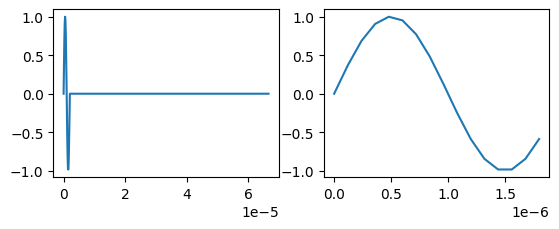

In [6]:
pulse = jnp.where(t_array < (1 / f0), jnp.sin(2 * jnp.pi * f0 * t_array), 0.0)

limit_i = int((1/f0) / t_axis.dt)
plt.subplot(2,2,1)
plt.plot(t_array, pulse)
plt.subplot(2,2,2)
plt.plot(t_array[0:limit_i], pulse[0:limit_i])
plt.show()

###

Let's also define one transmitter location, in the centre of the domain.

---

In [7]:
tx_loc_i = jnp.array([
    [Nx // 2, Ny // 2],
])

tx_loc_i.shape  # (1, 2) -> 1 transmitter, 2 spatial dimensions (x and y)

(1, 2)

###

This pulse has a shape of `(T,)`, but j-wave expects either `(1, T)`, where the same signal is applied to all transmitters; or `(N_tx, T)`, where each transmitter has its own signal. For now, we'll use the former, and add a leading singleton dimension to our pulse.

---

In [8]:
signals = pulse[jnp.newaxis, :]

signals.shape

(1, 556)

###

Now we can create another j-wave object of type `Sources`, which defines the injected energy into our simulation.

Importantly, j-wave expects the positions to be passed as a tuple of arrays, where each array corresponds to a spatial dimension. So for 2D, we need to pass two arrays: i.e. imagine we have 3 transmitters, then the positions would be:
```py
tx_loc_i = jnp.array([
    [x1, y1],
    [x2, y2],
    [x3, y3],
])
```
Then we need to pass the positions as:
```py
positions=([x1, x2, x3], [y1, y2, y3])
```

We can do this using tensor slicing: where `tx_loc_i[:, 0]`  gives us the first column of `tx_loc_i`, etc.

---

In [9]:
tx = Sources(
    positions=(
        tx_loc_i[:, 0],
        tx_loc_i[:, 1],
    ),
    signals=signals,
    domain=domain,
    dt=t_axis.dt,
)

###

Let's use a quick visualisation function to show where our transmitter is located.

---

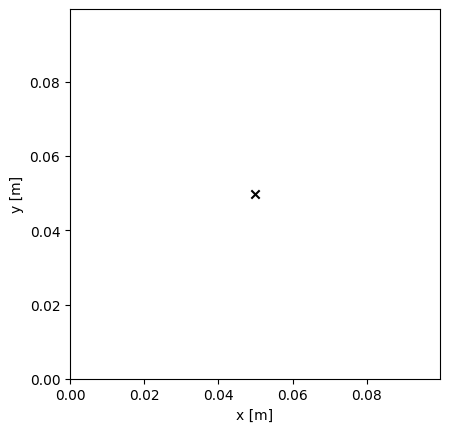

In [10]:
def plot_sources(sources, target=None):
    extent = [0, Nx * dx, 0, Ny * dy]
    plt.scatter(
        x=sources.positions[0] * dx,
        y=sources.positions[1] * dy,
        marker="x",
        color="k",
    )
    if target is not None:
        plt.scatter(
            x=target[:, 0] * dx,
            y=target[:, 1] * dy,
            marker="o",
            color="r",
        )
    plt.gca().set_aspect("equal")
    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.show()

plot_sources(tx)

## Our First Simulation!

###

We're now ready to run a simulation! We do so using j-wave's `simulate_wave_propagation` function.

---

In [11]:
result = simulate_wave_propagation(
    medium,
    t_axis,
    sources=tx,
)

print(result)

FourierSeries(
  params=f32[556,166,166,1],
  domain=Domain(N=(166, 166), dx=(0.0006000000000000001, 0.0006000000000000001))
)


###

Two important things can be seen here. Firstly, our result is a "FourierSeries" object, coming from `jaxdf`, which is what `j-wave` uses for discretisation under the hood. You can read more about it online, if interested. Secondly, notice the shape of our result: `(T, Nx, Ny, 1)`—i.e. a time-series of the 2D pressure field.

---

In [12]:
result.params.shape

(556, 166, 166, 1)

###

Let's visualise our result.

---

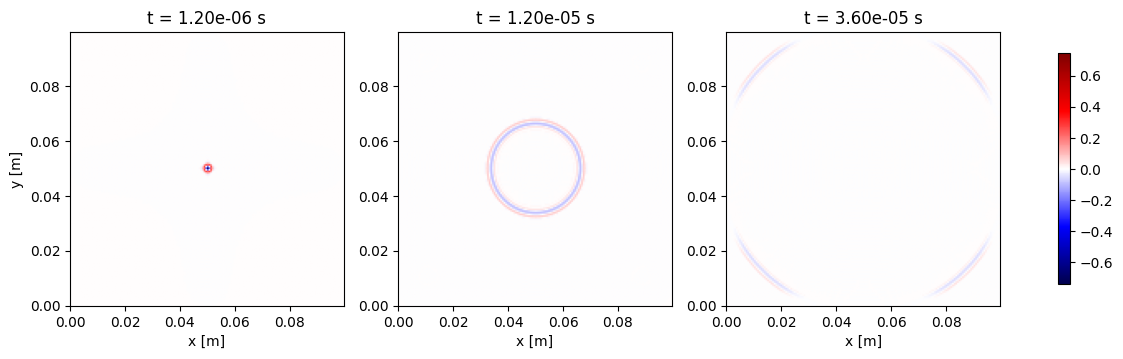

In [13]:
def plot_frames(result, t_indices):
    vmax = jnp.max(jnp.abs(result.params))
    extent = [0, Nx * dx, 0, Ny * dy]
    _, axs = plt.subplots(1, len(t_indices), figsize=(5 * len(t_indices), 5))
    for i in range(len(t_indices)):
        axs[i].imshow(
            result.params[t_indices[i], :, :, 0].T,
            vmax=vmax,
            vmin=-vmax,
            extent=extent,
            origin="lower",
            cmap="seismic",
        )
        axs[i].set_title(f"t = {t_indices[i] * t_axis.dt:.2e} s")
        axs[i].set_xlim(0, Nx * dx)
        axs[i].set_ylim(0, Ny * dy)
        axs[i].set_xlabel("x [m]")
    axs[0].set_ylabel("y [m]")
    plt.colorbar(axs[-1].images[0], ax=axs, location="right", shrink=0.6)
    plt.show()

plot_frames(result, [10, 100, 300])

###

We can also animate it over time.

---

In [14]:
def animate_result(result, time_downsample=16):
    fig, ax = plt.subplots()

    extent = [0, Nx * dx, 0, Ny * dy]
    data = result.params[::time_downsample, :, :, 0]
    vmax = jnp.max(jnp.abs(data))
    im = ax.imshow(data[0].T, vmin=-vmax, vmax=vmax, cmap="seismic", extent=extent, origin="lower")
    fig.colorbar(im)
    ax.set_xlim(0, Nx * dx)
    ax.set_ylim(0, Ny * dy)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    def update(frame):
        im.set_array(data[frame].T)
        return (im,)

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(data),
        interval=30,
        blit=True
    )

    plt.close()
    return HTML(anim.to_html5_video())

###

Note: animating takes a while to run

---

In [15]:
animate_result(result)

## Multiple Sources

###

Let's rather define our sources as percentages of the domain size.

---

In [16]:
def loc_perc_to_i(loc_perc):
    return loc_perc * jnp.array([[Nx, Ny]]) // 100

###

We'll now create a line of transmitters, with the same x position, and evenly spaced y positions.

---

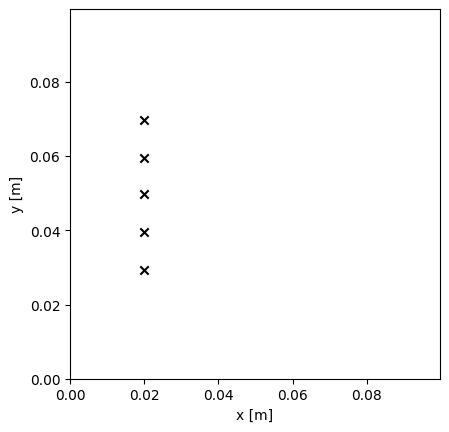

In [17]:
txA_loc_perc = jnp.array([
    [20, 30],
    [20, 40],
    [20, 50],
    [20, 60],
    [20, 70],
])

txA_loc_i = loc_perc_to_i(txA_loc_perc)

txA = Sources(
    positions=(txA_loc_i[:, 0], txA_loc_i[:, 1]),
    signals=signals, # We'll reuse the same signal from before
    domain=domain,
    dt=t_axis.dt,
)

plot_sources(txA)

###

We can easily simulate with the new sources. Notice in the far field, the summed wavefronts approach a plane wave, as expected.

---

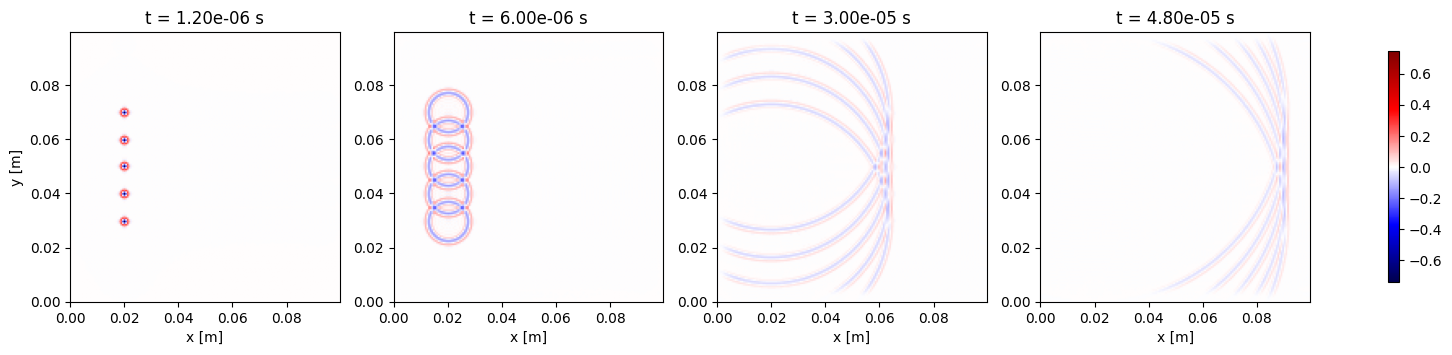

In [18]:
resultA = simulate_wave_propagation(
    medium,
    t_axis,
    sources=txA,
)

plot_frames(resultA, [10, 50, 250, 400])

## Focusing

###

How could we go about _focusing_ the wavefronts instead? We could try this geometrically:

---

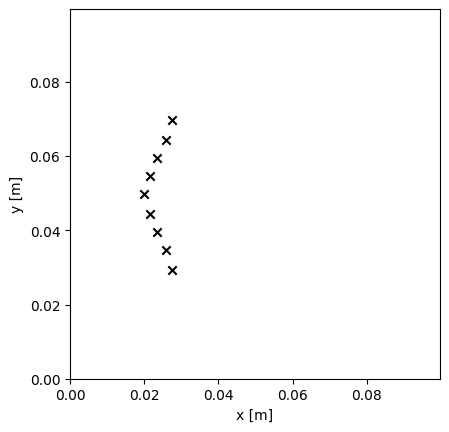

In [19]:
txB_loc_perc = jnp.array([
    [28, 30],
    [26, 35],
    [24, 40],
    [22, 45],
    [20, 50],
    [22, 55],
    [24, 60],
    [26, 65],
    [28, 70],
])

txB_loc_i = loc_perc_to_i(txB_loc_perc)

txB = Sources(
    positions=(txB_loc_i[:, 0], txB_loc_i[:, 1]),
    signals=signals,
    domain=domain,
    dt=t_axis.dt,
)

plot_sources(txB)

###


---

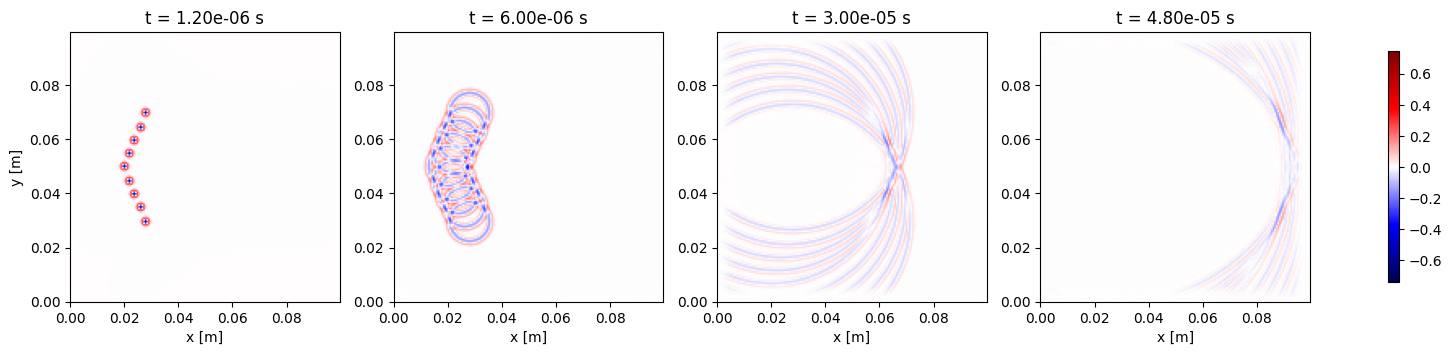

In [20]:
resultB = simulate_wave_propagation(
    medium,
    t_axis,
    sources=txB,
)

plot_frames(resultB, [10, 50, 250, 400])

###


---

In [21]:
animate_result(resultB)

###

How "good" is our focusing? A good way to visualise is to look at the maximum pressure over time, at each spatial location.

---

In [ ]:
def max_pressure_plot(result, target=None):
    extent = [0, Nx * dx, 0, Ny * dy]
    data = jnp.max(jnp.abs(result.params[:, :, :, 0]), axis=0)
    plt.imshow(data.T, extent=extent, origin="lower")
    if target is not None:
        plt.scatter(
            x=target[:, 0] * dx,
            y=target[:, 1] * dy,
            marker="o",
            color="r",
        )
    plt.xlim(0, Nx * dx)
    plt.ylim(0, Ny * dy)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.colorbar()
    plt.show()

max_pressure_plot(result)
max_pressure_plot(resultA)

###

Our latest result shows signs of a "focal point", but it's not very good—can you think of why?

---

In [ ]:
max_pressure_plot(resultB)

## Time Shifting ("Phased Array")

###

Also, we don't want to change the physical geometry of every target location. Instead, we want to fix the geometry, and apply a _time delay_ to each transmitter.

Let's define coordinates for a target.

---

In [ ]:
target_loc_perc = jnp.array([[70, 50]]) # Shape (1, 2)
target_loc_i = loc_perc_to_i(target_loc_perc)

plot_sources(txA, target=target_loc_i)

###

We're going to use `jnp.roll` to apply a time delay to each transmitter. This function rolls the elements of an array along a given axis, and wraps around the elements that fall off the end.

---

In [ ]:
plt.plot(t_array, pulse)
plt.plot(t_array, jnp.roll(pulse, 100))  # "rolling" the pulse by +100 time steps

# ^ Be careful here! This quick solution "wraps around"—so your pulse needs to be padded with zeros!!

plt.show()

###

But how do we compute the amount by which to roll each transmitter's pulse?

We can compute the distance from each transmitter to the target, and convert this distance into a time delay, using the speed of sound.

---

In [ ]:
target_diffs_i = (target_loc_i - txA_loc_i)
target_diffs_m = target_diffs_i * jnp.array([dx, dy])

target_dist_m = jnp.linalg.norm(target_diffs_m, axis=-1)

print(target_dist_m)

target_timediff_s = target_dist_m / c0  # [m] / [m/s] = [s]
target_timediff_i = (target_timediff_s / t_axis.dt).astype(int)

print(target_timediff_i)

###

But what's wrong here? We actually want the smallest distance to have the largest delay (for the waves to arrive at the target at the same time). Plus, notice that it's only the *relative* delays that matter. A convenient solution:

---

In [ ]:
target_delays_i = jnp.max(target_timediff_i) - target_timediff_i
target_delays_i

###

Now we can use the `jnp.roll` as discussed before.

---

In [ ]:
shifted_signals = jnp.array([jnp.roll(pulse, shift=delay) for delay in target_delays_i])
shifted_signals.shape

###

Let's visualise the shifted signals.

---

In [ ]:
_, axs = plt.subplots(len(target_delays_i), 1, figsize=(6, 8), sharex=True)
for i, delay in enumerate(target_delays_i):
    axs[i].plot(
        t_array,
        shifted_signals[i],
        label=f"Tx {i}, delay={delay} steps",
    )
    axs[i].legend(loc='upper right')
    axs[i].set_xlim(0, 3 / f0) # Show only the first few periods of the pulse

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

###

We can now use these shifted signals as a source, and run the simulation again.

---

In [ ]:
txC = Sources(
    positions=(txA_loc_i[:, 0], txA_loc_i[:, 1]),
    signals=shifted_signals,
    domain=domain,
    dt=t_axis.dt,
)

resultC = simulate_wave_propagation(
    medium,
    t_axis,
    sources=txC,
)

plot_frames(resultC, [10, 50, 250, 350])

###

---

In [ ]:
animate_result(resultC)

###

---

In [ ]:
max_pressure_plot(resultC, target=target_loc_i)

###

Let's encapsulate what we've done above into a function, for us to test various examples.

---

In [ ]:
from jax import Array

def ray_tracing(
    tx_loc_perc: Array, # Shape (N_tx, 2)
    target_loc_perc: Array, # Shape (1, 2)
    pulse: Array, # Shape (N_t,)
    domain: Domain,
    medium: Medium,
    t_axis: TimeAxis,
    c0: float,
    dx: float,
    dy: float,
):
    target_loc_i = loc_perc_to_i(target_loc_perc)
    tx_loc_i = loc_perc_to_i(tx_loc_perc)
    diffs_m = (target_loc_i - tx_loc_i) * jnp.array([dx, dy])
    dist_m = jnp.linalg.norm(diffs_m, axis=-1)  # (N_tx,)
    delays_s = dist_m / c0
    delays_i = (delays_s / t_axis.dt).astype(int)
    delays_i = jnp.max(delays_i) - delays_i
    shifted_signals = jnp.array([jnp.roll(pulse, shift=int(d)) for d in delays_i])
    tx = Sources(
        positions=(tx_loc_i[:, 0], tx_loc_i[:, 1]),
        signals=shifted_signals,
        domain=domain,
        dt=t_axis.dt,
    )
    result = simulate_wave_propagation(
        medium,
        t_axis,
        sources=tx,
    )
    return result

###

We should do a sanity check to make sure our function is working as expected, with an example we've seen before.

---

In [ ]:
res = ray_tracing(
    tx_loc_perc=txA_loc_perc,
    target_loc_perc=target_loc_perc,
    pulse=pulse,
    domain=domain,
    medium=medium,
    t_axis=t_axis,
    c0=c0,
    dx=dx,
    dy=dy,
)
plot_frames(res, [10, 50, 250, 350])

###

Q: How does the number of transmitters affect the quality of the focus?

---

In [ ]:
Ntx = 32
array_y_start_perc = 30
array_y_end_perc = 70

tx_loc_perc = jnp.array([[20, int(i)] for i in jnp.linspace(array_y_start_perc, array_y_end_perc, Ntx)])
target_loc_perc = jnp.array([[70, 50]])

res = ray_tracing(
    tx_loc_perc=tx_loc_perc,
    target_loc_perc=target_loc_perc,
    pulse=pulse,
    domain=domain,
    medium=medium,
    t_axis=t_axis,
    c0=c0,
    dx=dx,
    dy=dy,
)
plot_frames(res, [10, 50, 250, 350])
max_pressure_plot(res)

###

Q: What if we move the target point?

---

In [ ]:
target_loc_perc = jnp.array([[70, 70]])

res = ray_tracing(
    tx_loc_perc=tx_loc_perc,
    target_loc_perc=target_loc_perc,
    pulse=pulse,
    domain=domain,
    medium=medium,
    t_axis=t_axis,
    c0=c0,
    dx=dx,
    dy=dy,
)
plot_frames(res, [10, 50, 250, 350])
max_pressure_plot(res, target=loc_perc_to_i(target_loc_perc))

## Heterogeneous Medium

###

Imagine now there was some "aberrator" between the sources and the target. For now, we'll just assume this aberrator is a uniform layer of different sound speed. In reality, of course, aberrators are much more complex—consider the challenge of the human skull!

---

In [ ]:
c1 = 2800 # [m/s] Speed of sound in the aberrator
rho1 = 1850 # [kg/m^3] Density in the aberrator

x_region_start_perc = 36
x_region_end_perc = 44

c_map = jnp.ones((Nx, Ny)) * c0
c_map = c_map.at[int(Nx*x_region_start_perc/100):int(Nx*x_region_end_perc/100), :].set(c1)

rho_map = jnp.ones((Nx, Ny)) * rho0
rho_map = rho_map.at[int(Nx*x_region_start_perc/100):int(Nx*x_region_end_perc/100), :].set(rho1)

medium_het = Medium(
    domain=domain,
    sound_speed=c_map,
    density=rho_map,
)

extent = [0, Nx * dx, 0, Ny * dy]
plt.imshow(c_map.T, extent=extent, origin="lower")
plt.xlim(0, Nx * dx)
plt.ylim(0, Ny * dy)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar(label="Sound Speed [m/s]")
plt.title("Sound Speed Map of the Medium")
plt.show()

###

Let's see how our algorithm from before performs in the heterogeneous medium. Can you think of what might happen?

---

In [ ]:
res_het = ray_tracing(
    tx_loc_perc=tx_loc_perc,
    target_loc_perc=target_loc_perc,
    pulse=pulse,
    domain=domain,
    medium=medium_het,
    t_axis=t_axis,
    c0=c0,
    dx=dx,
    dy=dy,
)
plot_frames(res_het, [10, 50, 250, 350])
max_pressure_plot(res_het, target=loc_perc_to_i(target_loc_perc))

###

Animating the result helps understand what's going on.

---

In [ ]:
animate_result(res_het)

## Time-Reversal Methods

###

We won't have time to dig deeply into time-reversal, but let's understand the basic idea & see how it performs.

We start by simulating a wave propagating from the target to the sources (called the "beacon"), and recording the signals at the sources.

Then, we _time-reverse_ these recorded signals, and use them as new sources for a second simulation.

---

In [ ]:
def time_reversal(
    tx_loc_perc: Array, # Shape (N_tx, 2)
    target_loc_perc: Array, # Shape (1, 2)
    pulse: Array, # Shape (N_t,)
    domain: Domain,
    medium: Medium,
    t_axis: TimeAxis,
):
    target_loc_i = loc_perc_to_i(target_loc_perc)
    tx_loc_i = loc_perc_to_i(tx_loc_perc)

    # BEACON STEP
    beacon = Sources(
        positions=(target_loc_i[:, 0], target_loc_i[:, 1]),
        signals=pulse[jnp.newaxis, :],
        domain=domain,
        dt=t_axis.dt,
    )
    beacon_result = simulate_wave_propagation(
        medium,
        t_axis,
        sources=beacon,
    )

    beacon_signals_at_tx = beacon_result.params[:, tx_loc_i[:, 0], tx_loc_i[:, 1], 0].T

    # TIME-REVERSAL STEP
    reversed_signals = beacon_signals_at_tx[:, ::-1]

    tx = Sources(
        positions=(tx_loc_i[:, 0], tx_loc_i[:, 1]),
        signals=reversed_signals,
        domain=domain,
        dt=t_axis.dt,
    )
    tr_result = simulate_wave_propagation(
        medium,
        t_axis,
        sources=tx,
    )
    return beacon_result, tr_result

###

Quick aside: why does this work?

Consider the acoustic wave equation: $$\nabla^2 p-\frac{1}{c^2} \frac{\partial^2 p}{\partial t^2}=0$$

Because there's a second-order time derivative ($\frac{\partial^2}{\partial t^2}$), the equation remains identical whether you plug in $t$ or $−t$. i.e. If a function $p(r,t)$ is a valid solution (a wave moving forward), then $p(r,−t)$ is also a valid solution (the wave moving backward).

(Question: can you think of a situation where this might not hold?)

---

###

Let's see how it performs!

---


In [ ]:
beacon_result, tr_result = time_reversal(
    tx_loc_perc=tx_loc_perc,
    target_loc_perc=target_loc_perc,
    pulse=pulse,
    domain=domain,
    medium=medium_het,
    t_axis=t_axis,
)
plot_frames(tr_result, [100, 200, 400, 500])
max_pressure_plot(tr_result, target=loc_perc_to_i(target_loc_perc))

###

Let's animate the initial "beacon" step.

---

In [ ]:
animate_result(beacon_result)

###

And now the time-reversed step.

---

In [ ]:
animate_result(tr_result)

## Transcranial Example

###

Let's quickly consider a simplified transcranial case. We'll use a CT image of a human skull, which we can read using the `pydicom` library. Thanks to https://brainhack.vercel.app/fus for the data!

---

In [ ]:
%%capture
%pip install pydicom
!wget -q https://github.com/imperial-nsb/neurotech-soc-tutorial-feb2026/raw/refs/heads/main/skull_slice.dcm

###

---

In [ ]:
import pydicom

ds = pydicom.dcmread("skull_slice.dcm")
skull_ct = jnp.array(ds.pixel_array, dtype=jnp.float32)
skull_slice = jnp.roll((skull_ct)[:400, 700:1100], +100, axis=0)
pixel_spacing = jnp.array(ds.PixelSpacing) / 1000  # [m]

# Redefine grid variables for the skull
Nx, Ny = skull_slice.shape
dx, dy = float(pixel_spacing[0]), float(pixel_spacing[1])
Dx, Dy = Nx * dx, Ny * dy

domain = Domain(N=(Nx, Ny), dx=(dx, dy))

bone_mask = skull_slice > 20e3

c_bone, rho_bone = 2800.0, 1850.0
c_skull = jnp.where(bone_mask, c_bone, c0)
rho_skull = jnp.where(bone_mask, rho_bone, rho0)

medium_skull = Medium(domain=domain, sound_speed=c_skull, density=rho_skull)

# Recompute time axis for the new domain/medium
t_end = Dx / c0
t_axis = TimeAxis.from_medium(medium=medium_skull, cfl=cfl, t_end=t_end)
t_array = t_axis.to_array()

# Recompute pulse for the new time axis
pulse = jnp.where(t_array < (1 / f0), jnp.sin(2 * jnp.pi * f0 * t_array), 0.0)

# Redefine loc_perc_to_i for the new Nx, Ny
def loc_perc_to_i(loc_perc):
    return loc_perc * jnp.array([[Nx, Ny]]) // 100

# Visualise
extent = [0, Dx, 0, Dy]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(skull_slice.T, extent=extent, origin="lower", cmap="gray")
axs[0].set_title("CT Slice")
axs[1].imshow(c_skull.T, extent=extent, origin="lower")
axs[1].set_title("Speed of Sound Map")
for ax in axs:
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
plt.colorbar(axs[1].images[0], ax=axs[1], label="[m/s]")
plt.tight_layout()
plt.show()

###

---

In [ ]:
# Simulate
Ntx = 64
tx_skull_perc = jnp.array([[20, int(i)] for i in jnp.linspace(30, 70, Ntx)])
target_skull_perc = jnp.array([[70, 50]])

res_skull = ray_tracing(
    tx_loc_perc=tx_skull_perc,
    target_loc_perc=target_skull_perc,
    pulse=pulse,
    domain=domain,
    medium=medium_skull,
    t_axis=t_axis,
    c0=c0,
    dx=dx,
    dy=dy,
)

plot_frames(res_skull, [10, 50, 250, 400])
max_pressure_plot(res_skull, target=loc_perc_to_i(target_skull_perc))

###

Very interesting to see how the waves interact with the skull.

---

In [ ]:
def animate_result_skull(result, time_downsample = 32):
    fig, ax = plt.subplots()

    extent = [0, Nx * dx, 0, Ny * dy]
    data = result.params[::time_downsample, :, :, 0]
    vmax = jnp.max(jnp.abs(data))

    # Show the skull speed-of-sound map as background
    ax.imshow(c_skull.T, extent=extent, origin="lower", cmap="gray", alpha=0.5)

    # Overlay the pressure field
    im = ax.imshow(data[0].T, vmin=-vmax, vmax=vmax, cmap="seismic", extent=extent, origin="lower", alpha=0.7)
    fig.colorbar(im, label="Pressure")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    def update(frame):
        im.set_array(data[frame].T)
        return (im,)

    anim = animation.FuncAnimation(fig, update, frames=len(data), interval=30, blit=True)
    plt.close()
    return HTML(anim.to_html5_video())

animate_result_skull(res_skull)

###

How does time-reversal perform in this case?

---

In [ ]:
# Time reversal in skull example
beacon_skull, res_skull = time_reversal(
    tx_loc_perc=tx_skull_perc,
    target_loc_perc=target_skull_perc,
    pulse=pulse,
    domain=domain,
    medium=medium_skull,
    t_axis=t_axis,
)

plot_frames(res_skull, [10, 50, 250, 400])
max_pressure_plot(res_skull, target=loc_perc_to_i(target_skull_perc))

###



---

In [ ]:
animate_result_skull(beacon_skull)

###



---

In [ ]:
animate_result_skull(res_skull)

## Closing Remarks

https://github.com/imperial-nsb